In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages

In [94]:
def swift_voce(strain, alpha, A, epsilon_0, n, k0, Q, beta):
        swift_term = alpha * A * (epsilon_0 + strain) ** n
        voce_term = (1 - alpha) * (k0 + Q * (1 - np.exp(-beta * strain)))
        return swift_term + voce_term


def modified_swift_voce(strain, A, B, n, Q, epsilon0, alpha, beta):
        swift_part = A * (strain + epsilon0) ** n  # Swift law
        voce_part = Q * (1 - np.exp(-B * strain))  # Voce law
        damping = (1 - np.exp(-alpha * strain)) / (1 + beta * strain)  # Damping term
        return swift_part + voce_part * damping

def r_value(strain, c1, c2, c3):
        return c1 + c2 * (1-np.exp(-c3 * strain))


# Normal Swift-Voce fitting

In [27]:
def analyze_sv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
# Load data in
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
# Initial guesses for parameters [alpha, A, epsilon_0, n, k0, Q, beta]
    initial_guess = [0.5, 500, 0.01, 0.2, 300, 200, 10]

# Fit the curve
    params, _ = curve_fit(swift_voce, strain, stress, p0=initial_guess, maxfev=100000)
    
# Extract fitted parameters
    alpha, A, epsilon_0, n, k0, Q, beta = params

# Plot the experimental data and the fitted curve
    fitted_stress = swift_voce(strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(strain, fitted_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.show()

# Print fitted parameters
    print(f'Fitted Parameters:\nAlpha: {alpha:.4f}\nA: {A:.4f}\nEpsilon_0: {epsilon_0:.4f}\n'
      f'n: {n:.4f}\nK0: {k0:.4f}\nQ: {Q:.4f}\nBeta: {beta:.4f}\n')
    
# Calculate error metrics
    mse = np.mean((stress - fitted_stress) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(stress - fitted_stress))
    r_squared = 1 - np.sum((stress - fitted_stress) ** 2) / np.sum((stress - np.mean(stress)) ** 2)

    # Print error metrics
    print(f'Error Metrics:\n'
          f'MSE: {mse:.4f}\n'
          f'RMSE: {rmse:.4f}\n'
          f'MAE: {mae:.4f}\n'
          f'R-squared: {r_squared:.4f}')
    
# Extended strain for comparison (you might want to adjust this range)
    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    extended_stress = swift_voce(extended_strain, *params)
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()
    
    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)

    '''
    # Export stress and strain values
    stress_difference = stress - fitted_stress
    
    # Create a DataFrame with the required columns
    df = pd.DataFrame({
        'Experimental Strain': strain,
        'Experimental Stress': stress,
        'Fitted Stress': fitted_stress,
        'Stress Difference': stress_difference
    })
    extracted_strain = np.arange(0.1, 3.01, 0.01)
    extracted_stress = swift_voce(extracted_strain, *params)
    df2 = pd.DataFrame({
        'Extended Strain': extracted_strain,
        'Extended Stress': extracted_stress,
    })

    # Save the DataFrame to an Excel file with the file name based on the `title` argument
    output_file_path = f"{title}_stress_strain_comparison.xlsx"
    with pd.ExcelWriter(output_file_path) as writer:
        df.to_excel(writer, sheet_name='Comparison', index=False)
        df2.to_excel(writer, sheet_name='Extended Fit', index=False)
    
    print(f"Data has been exported to {output_file_path}")
    '''
    return params, extended_stress, extended_strain
   

# Modified Swift-Voce fitting with damping value for high strain

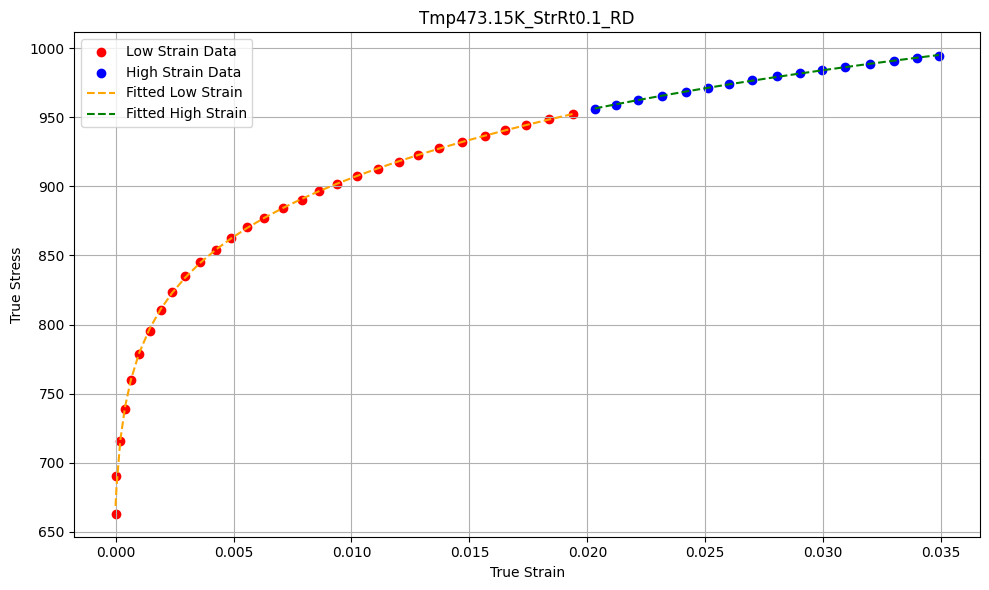

Fitted Parameters for Low Strain (<0.02):
A: 1223.7003, B: 49.4710, n: 0.0663, Q: 2184.8639, Epsilon_0: 0.0001, Alpha: 0.5332, Beta: 20.0000
Fitted Parameters for High Strain (>=0.02):
A: 1272.7564, B: 16.1398, n: 0.0733, Q: 567.5652, Epsilon_0: 0.0000, Alpha: 0.0000, Beta: 7.2264


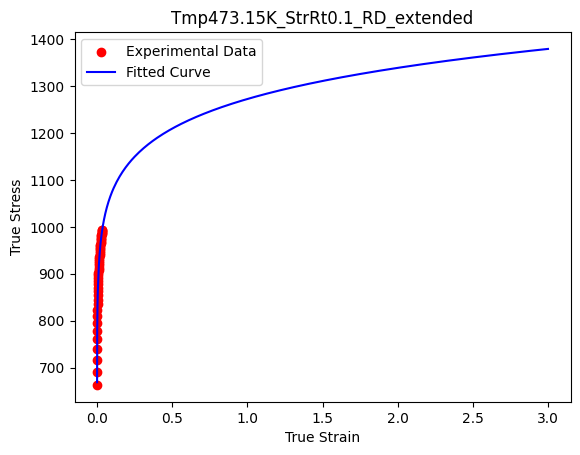

(array([1.22370026e+03, 4.94709809e+01, 6.63265899e-02, 2.18486388e+03,
        1.10223467e-04, 5.33209650e-01, 2.00000000e+01]),
 array([1.27275638e+03, 1.61397681e+01, 7.33382326e-02, 5.67565173e+02,
        9.32342797e-21, 3.30320324e-20, 7.22635822e+00]))

In [31]:
def analyze_msv_fit(file_path, strain_column, stress_column, title, initial_guess=None):
    # Load data
    data = pd.read_csv(file_path)
    strain = data[strain_column].dropna().values
    stress = data[stress_column].dropna().values
    
    # Initial guesses for parameters [A, B, n, K, epsilon0, alpha, beta]
    if initial_guess is None:
        initial_guess = [1500, 20, 0.2, 2000, 0.02, 0.3, 5] # Default values if not provided
    
    # Adjusted bounds to limit parameter values
    bounds = ([500, 0, 0, 500, 0, 0, 0], [5000, 50, 1, 5000, 0.2, 1, 20])

    # Separate data into low and high strain regions
    low_strain = strain[strain < 0.02]
    low_stress = stress[strain < 0.02]

    high_strain = strain[strain >= 0.02]
    high_stress = stress[strain >= 0.02]

    # Fit the curve for low strain data
    params_low, _ = curve_fit(
        modified_swift_voce, low_strain, low_stress, p0=initial_guess, bounds=bounds
    )

    # Fit the curve for high strain data
    params_high, _ = curve_fit(
        modified_swift_voce, high_strain, high_stress, p0=initial_guess, bounds=bounds
    )

    # Extract fitted stress values
    fitted_low_stress = modified_swift_voce(low_strain, *params_low)
    fitted_high_stress = modified_swift_voce(high_strain, *params_high)

    # Plot experimental and fitted curves
    plt.figure(figsize=(10, 6))
    plt.scatter(low_strain, low_stress, label='Low Strain Data', color='red')
    plt.scatter(high_strain, high_stress, label='High Strain Data', color='blue')
    plt.plot(low_strain, fitted_low_stress, color='orange', linestyle='--', label='Fitted Low Strain')
    plt.plot(high_strain, fitted_high_stress, color='green', linestyle='--', label='Fitted High Strain')
    
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print fitted parameters for both regions
    print(f'Fitted Parameters for Low Strain (<0.02):\n'
          f'A: {params_low[0]:.4f}, B: {params_low[1]:.4f}, n: {params_low[2]:.4f}, '
          f'Q: {params_low[3]:.4f}, Epsilon_0: {params_low[4]:.4f}, '
          f'Alpha: {params_low[5]:.4f}, Beta: {params_low[6]:.4f}')

    print(f'Fitted Parameters for High Strain (>=0.02):\n'
          f'A: {params_high[0]:.4f}, B: {params_high[1]:.4f}, n: {params_high[2]:.4f}, '
          f'Q: {params_high[3]:.4f}, Epsilon_0: {params_high[4]:.4f}, '
          f'Alpha: {params_high[5]:.4f}, Beta: {params_high[6]:.4f}')

    extended_strain = pd.read_csv("data/strain_extended.csv")['strain']
    low_stress = modified_swift_voce(extended_strain[extended_strain < 0.02], *params_low)
    high_stress = modified_swift_voce(extended_strain[extended_strain >= 0.02], *params_high)
    extended_stress = np.concatenate((low_stress, high_stress))
    plt.scatter(strain, stress, label='Experimental Data', color='red')
    plt.plot(extended_strain, extended_stress, label='Fitted Curve', color='blue')
    plt.xlabel('True Strain')
    plt.ylabel('True Stress')
    plt.title(f"{title}_extended")
    plt.legend()
    plt.show()

    # Create a DataFrame to save the results
    df = pd.DataFrame({
        'Strain': extended_strain,
        'Stress': extended_stress
    })

    # Save the DataFrame to a CSV file
    output_file_path = f"extended_curve/{title}.csv"  # Adjust the filename as needed
    df.to_csv(output_file_path, index=False)
    return params_low, params_high

#condition = 'Tmp298.15K_StrRt1_RD'
condition = 'Tmp473.15K_StrRt0.1_RD'
analyze_msv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp473.csv', condition + '_E', condition + '_S', condition)


# Plot of all strain rate and parameters relationship

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


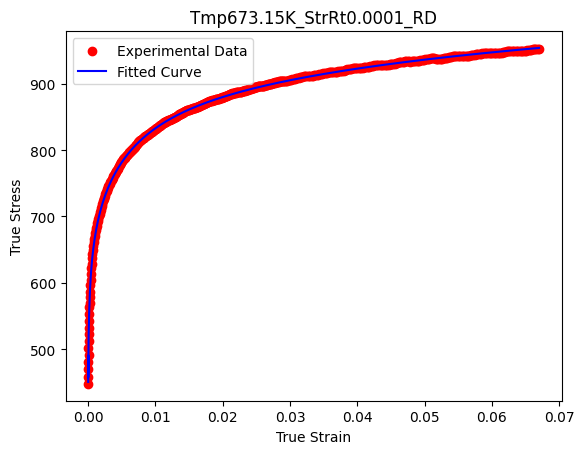

Fitted Parameters:
Alpha: 0.4608
A: 1071120.6963
Epsilon_0: 0.0000
n: 0.0001
K0: -913371.6424
Q: 73.1414
Beta: 183.6771

Error Metrics:
MSE: 5.3673
RMSE: 2.3167
MAE: 1.0788
R-squared: 0.9994


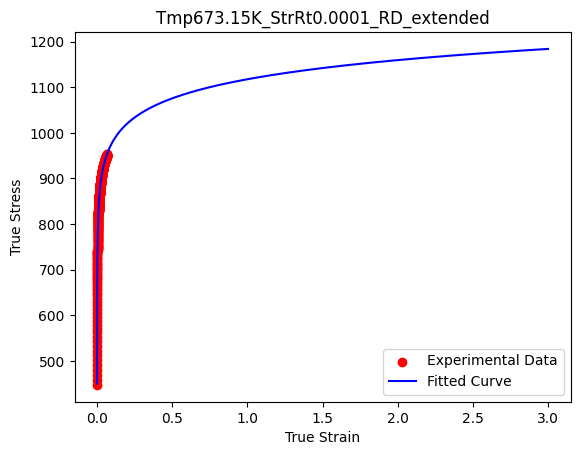

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


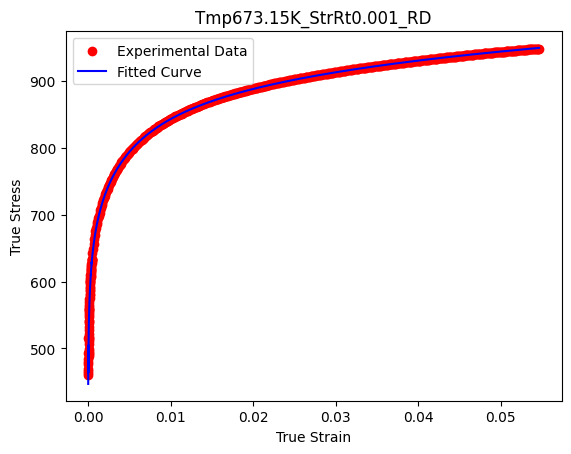

Fitted Parameters:
Alpha: 0.4578
A: 952214.0175
Epsilon_0: 0.0000
n: 0.0001
K0: -801826.5646
Q: 59.1985
Beta: 228.1955

Error Metrics:
MSE: 10.0890
RMSE: 3.1763
MAE: 1.0046
R-squared: 0.9993


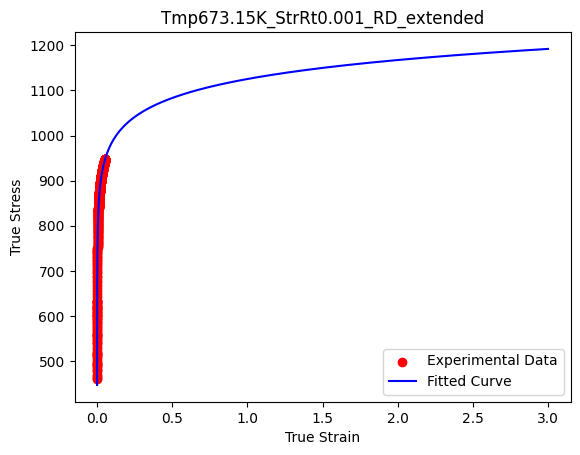

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


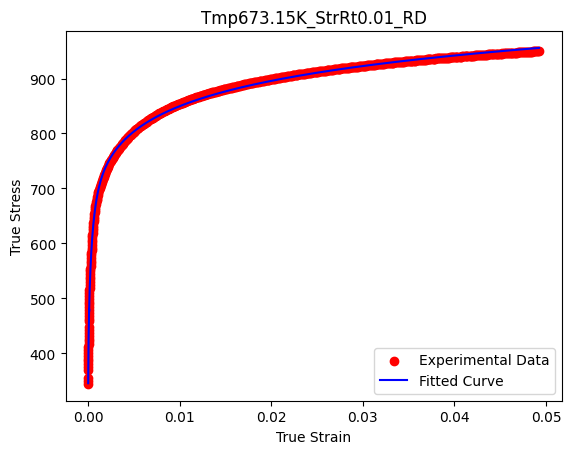

Fitted Parameters:
Alpha: 0.4358
A: 1402929.7554
Epsilon_0: 0.0000
n: 0.0001
K0: -1081807.2686
Q: 176.0583
Beta: 2373.7123

Error Metrics:
MSE: 27.3549
RMSE: 5.2302
MAE: 3.6027
R-squared: 0.9985


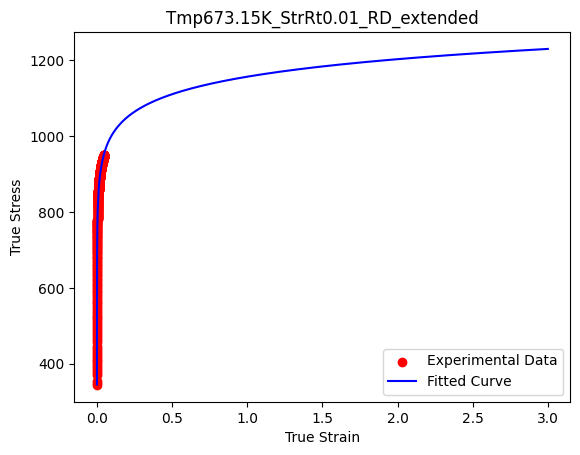

/var/folders/n_/7tqgdxqs259f7cnfxbsjqzwm0000gp/T/ipykernel_33275/496301290.py:2: RuntimeWarning: invalid value encountered in power
  swift_term = alpha * A * (epsilon_0 + strain) ** n


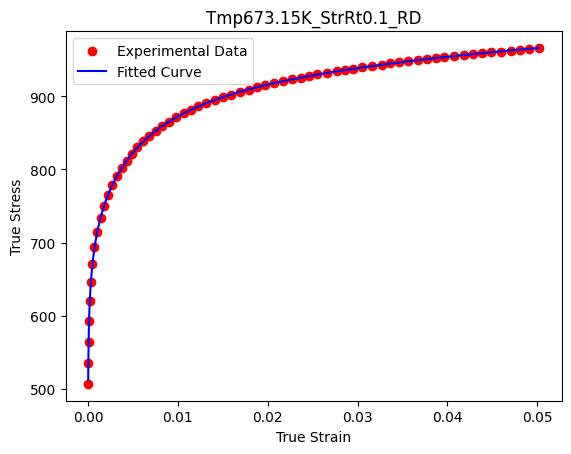

Fitted Parameters:
Alpha: 0.4645
A: 285977.1675
Epsilon_0: 0.0000
n: 0.0004
K0: -246088.9324
Q: 100.4017
Beta: 197.2025

Error Metrics:
MSE: 4.5256
RMSE: 2.1273
MAE: 0.8415
R-squared: 0.9997


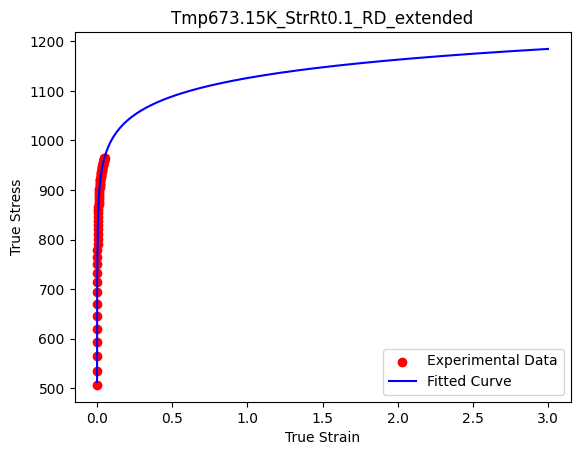

"\nfor i in range(7):\n    plt.figure(figsize=(8, 5))  # Create a new figure for each plot\n    plt.plot(conditions, [p[i] for p in params], marker='o')\n    plt.xlabel('Conditions')\n    plt.xticks(rotation=60)\n    plt.ylabel(params_name[i])\n    plt.title(params_name[i] + ' of Each Condition')\n    plt.tight_layout()  # Adjust layout to prevent label cut-off\n    plt.show()  # Display the plot\n"

In [37]:
params = [] #store all parameters
params_name  = ['alpha', 'A', 'epsilon_0', 'n', 'k0', 'Q', 'beta']

#conditions = ['Tmp77.15K_StrRt0.0001_RD']
#conditions = ['Tmp233.15K_StrRt0.0001_RD']
#conditions = ['Tmp298.15K_StrRt0.0001_RD', 'Tmp298.15K_StrRt0.0001_DD', 'Tmp298.15K_StrRt0.0001_TD', 'Tmp298.15K_StrRt0.001_RD', 'Tmp298.15K_StrRt0.001_DD', 'Tmp298.15K_StrRt0.001_TD', 'Tmp298.15K_StrRt0.01_RD', 'Tmp298.15K_StrRt0.01_DD', 'Tmp298.15K_StrRt0.01_TD', 'Tmp298.15K_StrRt0.1_RD','Tmp298.15K_StrRt0.1_DD', 'Tmp298.15K_StrRt0.1_TD']
#conditions = ['Tmp373.15K_StrRt0.0001_RD', 'Tmp373.15K_StrRt0.001_RD', 'Tmp373.15K_StrRt0.01_RD', 'Tmp373.15K_StrRt0.1_RD']
#conditions = ['Tmp473.15K_StrRt0.0001_RD', 'Tmp473.15K_StrRt0.001_RD', 'Tmp473.15K_StrRt0.01_RD']
#conditions = ['Tmp573.15K_StrRt0.0001_RD', 'Tmp573.15K_StrRt0.001_RD', 'Tmp573.15K_StrRt0.01_RD', 'Tmp573.15K_StrRt0.1_RD']
conditions = ['Tmp673.15K_StrRt0.0001_RD', 'Tmp673.15K_StrRt0.001_RD', 'Tmp673.15K_StrRt0.01_RD', 'Tmp673.15K_StrRt0.1_RD']

for condition in conditions:
    params.append(analyze_sv_fit('data/Exp_FC_StrRtDpn_TmpDpn_Tmp673.csv', condition + '_E', condition + '_S', condition))
'''
for i in range(7):
    plt.figure(figsize=(8, 5))  # Create a new figure for each plot
    plt.plot(conditions, [p[i] for p in params], marker='o')
    plt.xlabel('Conditions')
    plt.xticks(rotation=60)
    plt.ylabel(params_name[i])
    plt.title(params_name[i] + ' of Each Condition')
    plt.tight_layout()  # Adjust layout to prevent label cut-off
    plt.show()  # Display the plot
'''

# r value fitting and generation

Strain Rate: 0.0001
RD Params: [-3.96879003e-01  1.13149540e+00  3.17251524e+02  7.35030403e-01
  6.95428757e+01 -1.87687147e-02  1.86737289e-01]
DD Params: [ 2.27086898e+02  2.26029608e+01  1.35708342e+02 -2.35464094e+02
  1.41919307e+02 -1.66698301e-02  4.87406825e-01]
TD Params: [ 7.73936126e+01  9.35344114e+00  1.26732771e+02 -8.04421080e+01
  1.32715233e+02 -1.64650286e-02  4.86243304e-01]


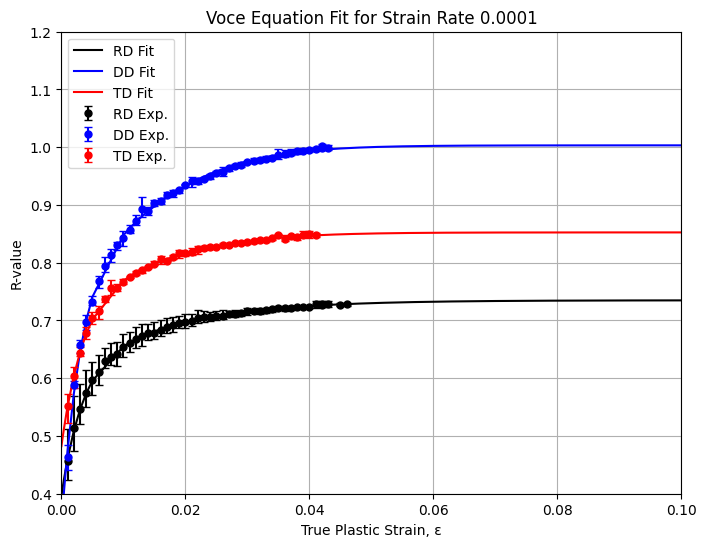

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Define the equation for r-value evolution
def r_value_eq(ε, c1, c2, C3, C4, C5, C6, alpha):
    term1 = alpha * (c1 + c2 * (1 - np.exp(-C3 * np.clip(ε, 0, 1e2))))
    term2 = (1 - alpha) * (C4 / (1 + np.exp(-C5 * (np.clip(ε, 0, 1e2) - C6))))
    return term1 + term2

# Define the residuals function
def residuals(params, strain, r_values):
    return r_value_eq(strain, *params) - r_values

# Load the data
file_path = 'data/Exp_rV_StrRtDpn_Tmp298.csv'  
data = pd.read_csv(file_path)

# Function to process data for the strain rate 0.0001
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col]
    rd_r_value = data[rd_col]
    dd_r_value = data[dd_col]
    td_r_value = data[td_col]
    
    rd_upper_error = data[rd_u_col]  # Upper error bar for RD
    rd_lower_error = data[rd_l_col]  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col]  # Upper error bar for DD
    dd_lower_error = data[dd_l_col]  # Lower error bar for DD
    
    td_upper_error = data[td_u_col]  # Upper error bar for TD
    td_lower_error = data[td_l_col]  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for the strain rate 0.0001
    initial_guess = [0.8, 0.1, 20, 0.5, 10, 0.02, 0.5]

    # Use least_squares to perform fitting
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean))
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean))
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean))

    # Generate fitted r-values for the strain range up to 3
    strain_fit = pd.read_csv("data/strain_extended.csv")['strain']
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 0.1])  # Adjust the x-axis limits as needed
    plt.ylim([0.4, 1.2])  # Adjust the y-axis limits as needed
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)

    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'extended_r/R_values_StrainRate_{strain_rate_label}.csv', index=False)

    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Define strain rate info for 0.0001
strain_rate_info_0001 = (
    '0.0001', 
    'Tmp298.15K_StrRt0.0001_RD_E', 
    'Tmp298.15K_StrRt0.0001_RD_r', 
    'Tmp298.15K_StrRt0.0001_DD_r', 
    'Tmp298.15K_StrRt0.0001_TD_r',
    'Tmp298.15K_StrRt0.0001_RD_U', 
    'Tmp298.15K_StrRt0.0001_RD_L', 
    'Tmp298.15K_StrRt0.0001_DD_U', 
    'Tmp298.15K_StrRt0.0001_DD_L', 
    'Tmp298.15K_StrRt0.0001_TD_U', 
    'Tmp298.15K_StrRt0.0001_TD_L'
)

# Process the strain rate 0.0001
rd_params, dd_params, td_params = process_strain_rate(*strain_rate_info_0001)

# Print the fitted parameters
print(f"Strain Rate: {strain_rate_info_0001[0]}")
print(f"RD Params: {rd_params}")
print(f"DD Params: {dd_params}")
print(f"TD Params: {td_params}")

Strain Rate: 0.001
RD Params: [8.20896401e-01 3.23023228e-01 5.00000000e+01 6.67456283e-01
 5.92020398e-13 3.48121818e-05 5.64619869e-01]
DD Params: [ 1.          0.9999799   3.47949733  0.99998253 29.99743112  0.05958232
  0.97240315]
TD Params: [ 1.          0.99943625  1.06738251  1.         29.99999977  0.05944072
  0.71630864]

Strain Rate: 0.01
RD Params: [6.96953836e-01 5.34610621e-01 5.00000000e+01 5.75001038e-01
 1.51754362e-10 2.34861856e-05 5.85179884e-01]
DD Params: [1.00000000e+00 2.93245037e-02 5.00000000e+01 1.00000000e+00
 1.41462786e+01 8.65764319e-10 1.00000000e+00]
TD Params: [1.00000000e+00 2.28012286e-03 5.00000000e+01 1.00000000e+00
 2.46740767e+01 6.52628037e-14 1.00000000e+00]

Strain Rate: 0.1
RD Params: [9.09737223e-01 1.97820578e-13 4.99999998e+01 8.84901471e-01
 3.19641723e-11 8.13590654e-01 6.40434998e-01]
DD Params: [1.00000000e+00 1.29838232e-01 4.99999994e+01 2.13072367e-01
 1.23400550e-03 2.94448191e-10 1.00000000e+00]
TD Params: [1.00000000e+00 1.04298

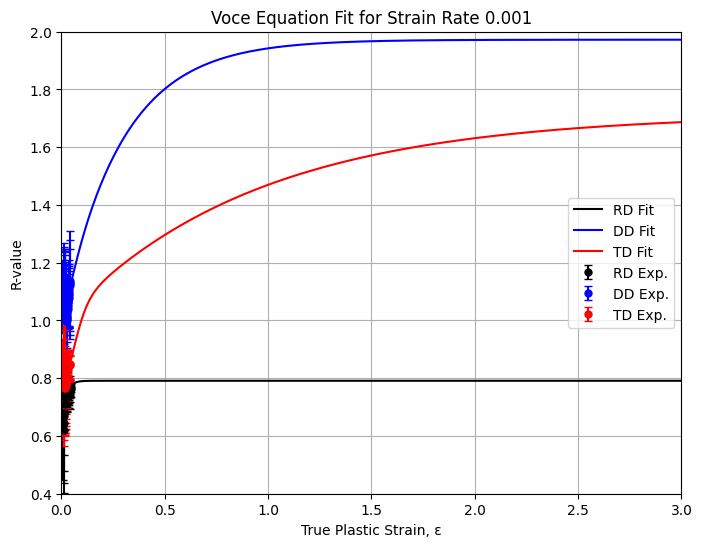

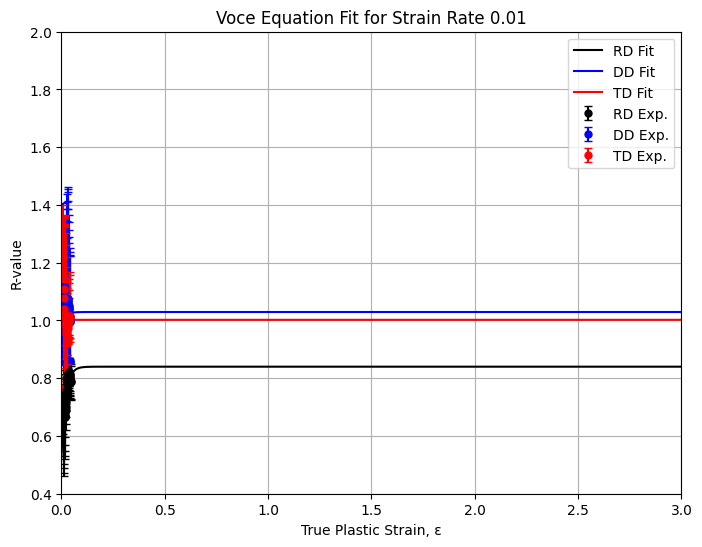

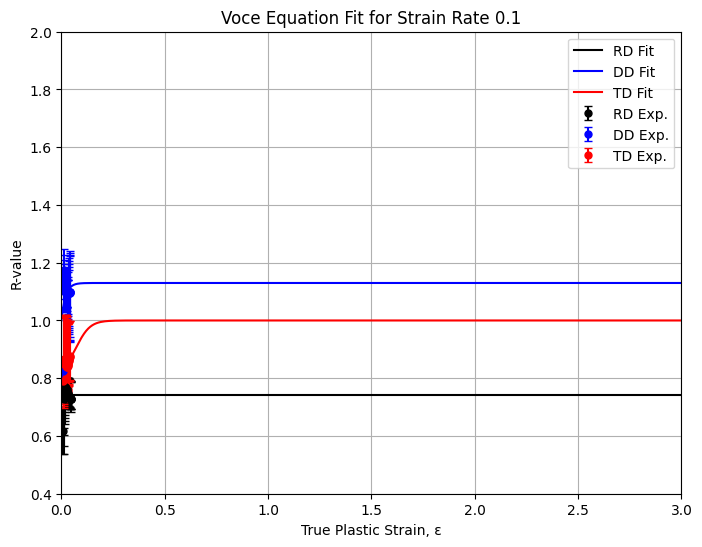

In [5]:
# Define the residuals function
#def residuals(params, strain, r_values):
#   return r_value_eq(strain, *params) - r_values
def residuals(params, strain, r_values, penalty_weight=100.0):
    r_fit = r_value_eq(strain, *params)
    residuals = r_fit - r_values
    penalty = penalty_weight * (r_fit[-1] - r_values[-1])**2  # penalty term for constant R-value at high strains
    return np.concatenate((residuals, [penalty]))

# Function to process data for each strain rate
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col].values
    rd_r_value = data[rd_col].values
    dd_r_value = data[dd_col].values
    td_r_value = data[td_col].values
    
    rd_upper_error = data[rd_u_col].values  # Upper error bar for RD
    rd_lower_error = data[rd_l_col].values  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col].values  # Upper error bar for DD
    dd_lower_error = data[dd_l_col].values  # Lower error bar for DD
    
    td_upper_error = data[td_u_col].values  # Upper error bar for TD
    td_lower_error = data[td_l_col].values  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for each strain rate
    initial_guesses = {
        '0.001': [0.75, 0.35, 20, 0.60, 10, 0.020, 0.5],
        '0.01': [0.65, 0.25, 18, 0.55, 13, 0.025, 0.4],
        '0.1': [0.55, 0.45, 32, 0.90, 7, 0.010, 0.3]
    }

    # Get initial guesses for the parameters
    initial_guess = initial_guesses.get(strain_rate_label, [0.5] * 7)

    # Set bounds for the parameters
    bounds = (
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Lower bounds
        [1.0, 1.0, 50.0, 1.0, 30.0, 1.0, 1.0]  # Upper bounds
    )

    # Attempt to fit the data
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean), bounds=bounds)
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean), bounds=bounds)
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean), bounds=bounds)

    # Generate fitted r-values for the strain range up to 3
    strain_fit = pd.read_csv("data/strain_extended.csv")['strain']
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 3])  # Adjusting the x-axis limits
    plt.ylim([0.4, 2])  # Adjusting the y-axis limits
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)
    
    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'extended_r/R_values_StrainRate_{strain_rate_label}.csv', index=False)
    
    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Process each strain rate
strain_rate_info = [
    ('0.001', 'Tmp298.15K_StrRt0.001_RD_E', 'Tmp298.15K_StrRt0.001_RD_r', 'Tmp298.15K_StrRt0.001_DD_r', 'Tmp298.15K_StrRt0.001_TD_r',
     'Tmp298.15K_StrRt0.001_RD_U', 'Tmp298.15K_StrRt0.001_RD_L', 'Tmp298.15K_StrRt0.001_DD_U', 'Tmp298.15K_StrRt0.001_DD_L', 'Tmp298.15K_StrRt0.001_TD_U', 'Tmp298.15K_StrRt0.001_TD_L'),
    ('0.01', 'Tmp298.15K_StrRt0.01_RD_E', 'Tmp298.15K_StrRt0.01_RD_r', 'Tmp298.15K_StrRt0.01_DD_r', 'Tmp298.15K_StrRt0.01_TD_r',
     'Tmp298.15K_StrRt0.01_RD_U', 'Tmp298.15K_StrRt0.01_RD_L', 'Tmp298.15K_StrRt0.01_DD_U', 'Tmp298.15K_StrRt0.01_DD_L', 'Tmp298.15K_StrRt0.01_TD_U', 'Tmp298.15K_StrRt0.01_TD_L'),
    ('0.1', 'Tmp298.15K_StrRt0.1_RD_E', 'Tmp298.15K_StrRt0.1_RD_r', 'Tmp298.15K_StrRt0.1_DD_r', 'Tmp298.15K_StrRt0.1_TD_r',
     'Tmp298.15K_StrRt0.1_RD_U', 'Tmp298.15K_StrRt0.1_RD_L', 'Tmp298.15K_StrRt0.1_DD_U', 'Tmp298.15K_StrRt0.1_DD_L', 'Tmp298.15K_StrRt0.1_TD_U', 'Tmp298.15K_StrRt0.1_TD_L')
]

# Loop through strain rates and print fitted parameters
for strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col in strain_rate_info:
    rd_params, dd_params, td_params = process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col)
    
    # Check if parameters are returned successfully
    if rd_params is not None and dd_params is not None and td_params is not None:
        print(f"Strain Rate: {strain_rate_label}")
        print(f"RD Params: {rd_params}")
        print(f"DD Params: {dd_params}")
        print(f"TD Params: {td_params}\n")
    else:
        print(f"Failed to fit parameters for strain rate {strain_rate_label}.\n")


# Calculating ratio between RD, TD, DD, biaxial and generate files for stress-strain simulation

In [12]:
directions = ['RD', 'DD', 'TD']
ref_temp = '298.15'

temps = ['77.15', '233.15']
strain_rates = [0.0001]

#strain_rates = [0.0001, 0.001, 0.01, 0.1]
#temps = ['298.15', '373.15', '473.15', '573.15', '673.15']

#RD-biaxial ratio from Zinan file
data_biax = pd.read_csv('data/strain_extended.csv')
ratio_biax = data_biax['biaxial']/data_biax['RD']

for strain_rate in strain_rates:
    data_RD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_RD.csv')
    data_DD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_DD.csv')
    data_TD = pd.read_csv(f'extended_curve/Tmp{ref_temp}K_StrRt{strain_rate}_TD.csv')
    r = pd.read_csv(f'extended_r/R_values_StrainRate_{strain_rate}.csv')
    
    #RD-DD and RD-TD ratio
    ratio = [data_DD['Stress']/data_RD['Stress'], data_TD['Stress']/data_RD['Stress'], ratio_biax]

    #Generate TD, DD, biaxial for all conditions
    for temp in temps:
        #Read in RD data
        temp_RD = pd.read_csv(f'extended_curve/Tmp{temp}K_StrRt{strain_rate}_RD.csv')['Stress']
        
        df = pd.DataFrame({
        'strain': data_RD['Strain'],
        'RD': temp_RD,
        'DD': temp_RD * ratio[0],
        'TD': temp_RD * ratio[1],
        'biaxial': temp_RD * ratio[2],
        'r_RD': r['RD_R_value'],
        'r_DD': r['DD_R_value'],
        'r_TD': r['TD_R_value']
    })

        # Save the DataFrame to a CSV file
        output_file_path = f"inp_file/Tmp{temp}K_StrRt{strain_rate}.csv"  # Adjust the filename as needed
        df.to_csv(output_file_path, index=False)